In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00


In [ ]:
# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds

# Import ResNet50 model and layers from Keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

# Import Matplotlib for plotting
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
(ds_train, ds_validation), ds_info = tfds.load(
    'malaria', # Load the malaria dataset
    split=['train[:80%]', 'train[80%:]'], # Split dataset into 80% training and 20% validation
    as_supervised=True, # Load data as (image, label) pairs
    with_info=True
)

# Define input shape for ResNet50
input_shape = (224, 224, 3)

# Define the preprocessing function with data augmentation
def preprocess_with_augmentation(image, label):
    # Apply random transformations to the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)

    # Resize image to match ResNet50 input size
    image = tf.image.resize(image, (input_shape[0], input_shape[1]))

    # Normalize pixel values
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

# Apply data augmentation to the training dataset
ds_train_augmented = ds_train.map(preprocess_with_augmentation)

# Batch and prefetch the augmented dataset
ds_train_augmented = ds_train_augmented.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Preprocess the validation dataset
def preprocess(image, label):
    image = tf.image.resize(image, (input_shape[0], input_shape[1]))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_validation = ds_validation.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteD6H4WR/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Define the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output) # Global average pooling layer
x = Dense(256, activation='relu')(x) # Fully connected layer with ReLU activation
x = Dropout(0.8)(x)
output = Dense(1, activation='sigmoid')(x) # Output layer with sigmoid activation (binary classification)
model = Model(inputs=base_model.input, outputs=output)


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Compile the model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model on the augmented training dataset, validating on the validation dataset
history = model.fit(ds_train_augmented, epochs=9, validation_data=ds_validation)

Epoch 1/3
689/689 [==============================] - 309s 348ms/step - loss: 0.1502 - accuracy: 0.9486 - val_loss: 1.3197 - val_accuracy: 0.5138
Epoch 2/3
689/689 [==============================] - 235s 341ms/step - loss: 0.1046 - accuracy: 0.9659 - val_loss: 0.1015 - val_accuracy: 0.9657
Epoch 3/3
689/689 [==============================] - 236s 342ms/step - loss: 0.0950 - accuracy: 0.9697 - val_loss: 0.0997 - val_accuracy: 0.9675


In [ ]:
# Evaluate the model on the validation dataset
evaluation = model.evaluate(ds_validation)

loss = evaluation[0]
accuracy = evaluation[1]

# Print validation loss and accuracy
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


173/173 [==============================] - 17s 97ms/step - loss: 0.0997 - accuracy: 0.9675
Validation Loss: 0.09965988993644714
Validation Accuracy: 0.9675254225730896


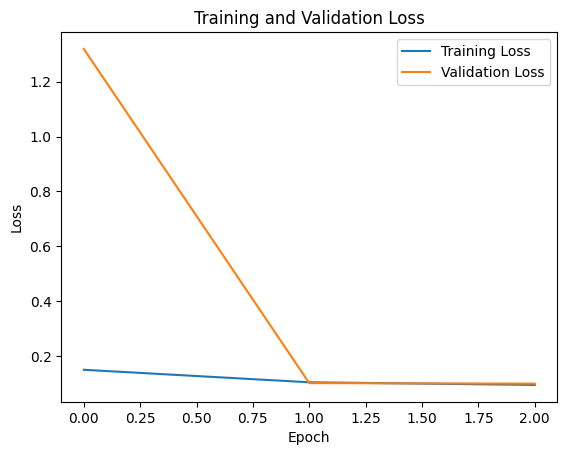

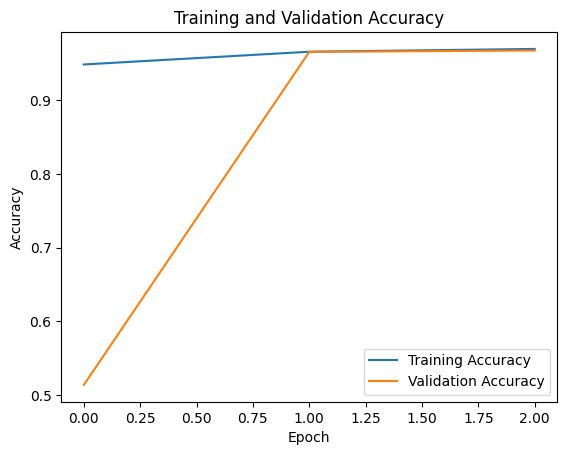

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()